# Hyrax Demonstration

For this demonstration we'll walk through a simplified version of a typical machine learning workflow supported by Hyrax.

In [1]:
import hyrax
import pooch
import subprocess

import chromadb
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import IFrame

from hyrax.config_utils import find_most_recent_results_dir
from mpr_demo_plotting import sort_objects_by_median_distance, plot_grid, plot_umap

## Download a sample HSC dataset

In [ ]:
file_path = pooch.retrieve(
    # DOI for Example HSC dataset
    url="doi:10.5281/zenodo.14498536/hsc_demo_data.zip",
    known_hash="md5:1be05a6b49505054de441a7262a09671",
    fname="example_hsc_new.zip",
    path="../../data",
    processor=pooch.Unzip(extract_dir="."),
)

/Users/drew/code/hyrax/data/./example_hsc_new.zip


This dataset is comprised of approximately 993 cutouts from the Hyper Suprime Cam survey.
Each cutout includes i, r and g bands and is 8 arcseconds on a side.


## Create and configure a Hyrax object

In [3]:
h = hyrax.Hyrax()

[2025-05-06 15:26:07,810 hyrax:INFO] Runtime Config read from: /Users/drew/code/hyrax/src/hyrax/hyrax_default_config.toml


An instance of the `Hyrax` class will be used through out this demo.
Under the hood when it is created, it will:
-  Load the configuration file specified (here it's using the built in default).
-  Parse the configuration file for external libraries and add those to the appropriate registries.
-  Prepare logging for the system.

In [4]:
# Specify the location of the data to use for training
h.config["general"]["data_dir"] = "../../data/hsc_8asec_1000"

# Specify the dataset class that represents the data
h.config["data_set"]["name"] = "HSCDataSet"
h.config["data_set"]["train_size"] = 0.8
h.config["data_set"]["validate_size"] = 0.2
h.config["data_set"]["test_size"] = 0.0

# Select the model to use for training
h.config["model"]["name"] = "HyraxAutoencoder"

# Set the number of epochs and batch size for training.
h.config["train"]["epochs"] = 20
h.config["data_loader"]["batch_size"] = 32

The default configuration needs a few tweaks to work for this demo.
We've updated the location of our sample data, and specified which model we want to train.

The configuration is represented as nested python dictionary. This allows for easy manipulation in a notebook via the `.config` attribute of the hyrax instance.

## Train a model

In [ ]:
h.train()

When we call `.train()` to train the model there's a lot going on under the hood:
- The model is automatically loaded onto the fastest hardware available.
- A data loader is instantiated and configured to load batches of data to the same hardware.
- A new timestamped directory is created under the configured results directory where all output is saved.
- The configuration becomes immutable and a copy is saved for reproducibility.
- The model and system metrics start being logged for review in both TensorBoard and MLFlow.
- Checkpoints are saved automatically both at the last epoch and at the epoch with the lowest loss value.
- Finally the model weights file is saved.

Training time depends heavily on the hardware available, model, and training parameters.
For a point of reference training takes about 40s for this case:
- Model trained: Hyrax autoencoder
- Dataset and size: Example HSC data, 993 samples, 96x96 pixel cutouts
- Number of epochs: 20
- Batch size: 32
- Hardware: Desktop with GTX 1660 Super GPU

While we train on only about 1000 samples here, Hyrax training has scaled up to over 1M samples on an HPC system with access to multiple GPUs without requiring the user to make any code changes.
To do so, the command line interface of Hyrax was used to work within a Slurm environment like so:
```
>> hyrax train --runtime-config ./results/<timestamped_directory>/runtime_config.toml
```

## Running inference

In [ ]:
# Update the data set splits to be 100% test data
h.config["data_set"]["test_size"] = 1.0
h.config["data_set"]["train_size"] = 0.0
h.config["data_set"]["validate_size"] = 0.0

# Increase batch size for faster inference
h.config["data_loader"]["batch_size"] = 512

# Run inference
h.infer()

For this demo, we'll pretend that of all the models we trained, the last one performed best.
We'll now use that model to run inference.
Note that by default, Hyrax will find the weights of the last successfully trained model for inference, but of course, a different set of weights can be specified in the configuration.

First we make a small update to the data set splits, setting `test_size` to 100% and the other splits to 0%.
We also increase the batch size in order to make better use of the available GPU memory.

Finally we run inference over the dataset using the trained model weights with `h.infer()`.
As with training, Hyrax is doing a lot behind the scenes on behalf of the user including:
- Identifying and using the most performant hardware available.
- Creating a new timestamped directory where all output is saved.
- Freezing the configuration and saving a copy for reproducibility.
- Saving the results of inference in batched .npy files.
- Optionally persisting the results to a vector database.

Again, while predicting the latent space for only 1000 samples here, Hyrax inference has scaled up to over 1M samples on an HPC system with access to multiple GPUs without requiring any code changes.

## Examine an embedding

In [17]:
h.umap()

[2025-05-06 15:34:17,116 hyrax.data_sets.inference_dataset:INFO] Using most recent results dir /Users/drew/code/hyrax/docs/pre_executed/results/20250506-134633-infer-uEOR for lookup. Use the [results] inference_dir config to set a directory or pass it to this verb.
[2025-05-06 15:34:17,358 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.
[2025-05-06 15:34:17,358 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.
[2025-05-06 15:34:17,359 hyrax.config_utils:WARNING] Cannot find default_config.toml for umap.
[2025-05-06 15:34:17,388 hyrax.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...
[2025-05-06 15:34:17,391 hyrax.data_sets.fits_image_dataset:INFO] FitsImageDataSet has 993 objects
[2025-05-06 15:34:17,403 hyrax.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning
[2025-05-06 15:34:17,404 hyrax.verbs.umap:INFO] Saving UMAP results to /Users/drew/code/hyrax/docs/pre_executed/results/20250506-153

Creating lower dimensional representation using UMAP::   0%|          | 0/32 [00:00<?, ?it/s]

[2025-05-06 15:34:24,532 hyrax.verbs.umap:INFO] Finished transforming all data through UMAP
[2025-05-06 15:34:24,556 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.
[2025-05-06 15:34:24,556 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.
[2025-05-06 15:34:24,557 hyrax.config_utils:WARNING] Cannot find default_config.toml for umap.
[2025-05-06 15:34:24,579 hyrax.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...
[2025-05-06 15:34:24,581 hyrax.data_sets.fits_image_dataset:INFO] FitsImageDataSet has 993 objects
[2025-05-06 15:34:24,593 hyrax.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning


Here we are using the output of the latest inference run to inform a UMAP fitter and then plot the resulting lower dimensional space.
With only about 1000 samples, it's hard to visually identify obvious groupings in the 2D space.

While fitting and transforming is made fairly straightforward with the `umap-learn` API, additional data plumbing is provided by FIBAD.
We ensure that file output of the inference step allows for efficient fitting and transformation with UMAP and all of the data plumbing to read from inference and write results is taken care of.

To support further exploration of the embedding space, FIBAD includes an early implementation of an interactive visualization tool.

## Interactive visualization

[2025-05-06 15:34:54,864 hyrax.data_sets.inference_dataset:INFO] Using most recent results dir /Users/drew/code/hyrax/docs/pre_executed/results/20250506-153417-umap-U4p6 for lookup. Use the [results] inference_dir config to set a directory or pass it to this verb.
[2025-05-06 15:34:54,887 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.
[2025-05-06 15:34:54,888 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.
[2025-05-06 15:34:54,888 hyrax.config_utils:WARNING] Cannot find default_config.toml for umap.
[2025-05-06 15:34:54,910 hyrax.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...
[2025-05-06 15:34:54,912 hyrax.data_sets.fits_image_dataset:INFO] FitsImageDataSet has 993 objects
[2025-05-06 15:34:54,924 hyrax.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
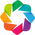

In [19]:
h.config["visualize"]["fields"] = ["ra", "dec"]
viz = h.visualize(width=1000, height=1000)

The Hyrax visualization tooling utilizes Holoviews, Datashader as well as an efficient tree structure to be able to display millions of points.
It allows for panning, zooming as well as lasso and box selections.
When selecting points, the resulting object ids are displayed are displayed in the associated table.

While this is an early version of interactive visualization, it has been scaled up to millions of data points.
The next steps for this tooling will be to support deeper interactivity, namely:
-  Automatically displaying the object selected in the table
-  Leveraging the vector db to identify similar objects
-  Supporting three dimensional UMAP output


This visualization runs in a notebook but when rendered to HTML (for demonstration or documentation) the server backing the interactive visual isn't packaged with the rendering. If the cell above was run locally, the resulting UI would look similar to the following screen shot.

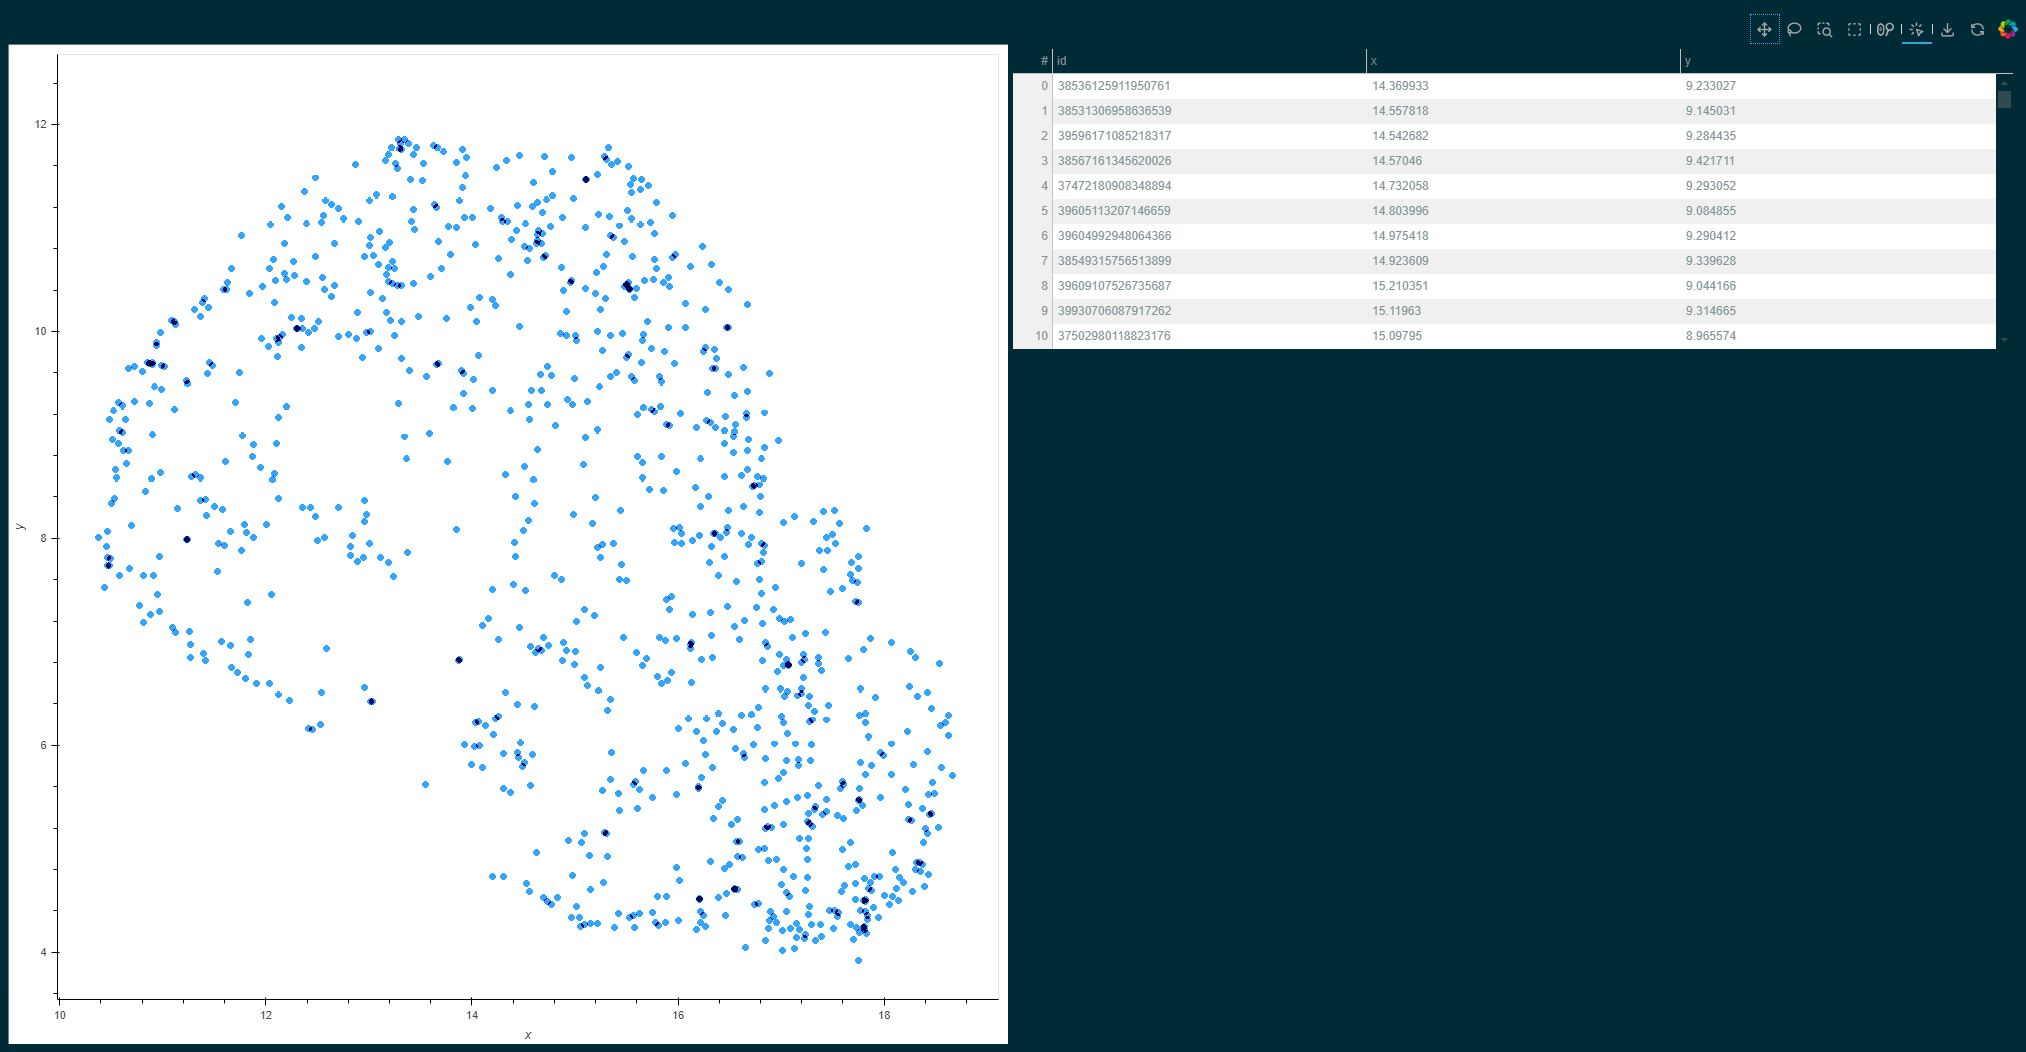


## Create a vector database
By calling the `index` verb, we can populate a vector database with the results of inference. This vector database can be used for efficient similarity or nearest neighbor searches.

In [9]:
h.index()

[2025-05-06 15:29:39,447 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.
[2025-05-06 15:29:39,448 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.
[2025-05-06 15:29:39,448 hyrax.config_utils:WARNING] Cannot find default_config.toml for umap.
[2025-05-06 15:29:39,470 hyrax.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...
[2025-05-06 15:29:39,472 hyrax.data_sets.fits_image_dataset:INFO] FitsImageDataSet has 993 objects
[2025-05-06 15:29:39,484 hyrax.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning
[2025-05-06 15:29:39,544 hyrax.verbs.vdb_index:INFO] Number of inference result batches to index: 2.
100%|██████████| 2/2 [00:00<00:00, 28.52it/s]


## Get an instance of the dataset

In [20]:
hsc_dataset = h.prepare()

[2025-05-06 15:35:02,379 hyrax.data_sets.hsc_data_set:INFO] Checking file dimensions to determine standard cutout size...
[2025-05-06 15:35:02,381 hyrax.data_sets.fits_image_dataset:INFO] FitsImageDataSet has 993 objects
[2025-05-06 15:35:02,392 hyrax.data_sets.hsc_data_set:INFO] Processed 993 objects for pruning
[2025-05-06 15:35:02,393 hyrax.data_sets.fits_image_dataset:INFO] Preloading FitsImageDataSet cache...
[2025-05-06 15:35:02,393 hyrax.prepare:INFO] Finished Prepare


[2025-05-06 15:35:05,557 hyrax.data_sets.fits_image_dataset:INFO] Processed 992 objects
